# 가위바위보 분류기 만들기

In [1]:
# 라이브러리 체크
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# # 디렉토리 만들기
# ! mkdir -p ~/aiffel/rock_scissor_paper/scissor
# ! mkdir -p ~/aiffel/rock_scissor_paper/rock
# ! mkdir -p ~/aiffel/rock_scissor_paper/paper

# ! ls -l ~/aiffel/rock_scissor_paper

In [3]:
# # 터미널에서 직접 실행 필요

# # 원하는 디렉토리로 이동 =3
# ! cd  ~/aiffel/rock_scissor_paper/rock

# # 압축 해제 명령어 : unzip <파일명>.zip
# ! unzip rock-samples.zip

# # 가위, 보에 대해서도 똑같이 실행!
# ! cd  ~/aiffel/rock_scissor_paper/scissor
# ! unzip scissor-samples.zip

# ! cd  ~/aiffel/rock_scissor_paper/paper
# ! unzip paper-samples.zip

__데이터 벌러오기+Resize하기__
- 우리가 학습한 이미지 크기가 28x28이기 때문에 가져온 데이터도 바꿔줘야 한다.  

In [4]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [5]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "data/train/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

3488  images to be resized.
3488  images resized.
가위 이미지 resize 완료!


In [6]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "data/train/rock"


# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
resize_images(image_dir_path)

3278  images to be resized.
3278  images resized.


In [7]:
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "data/train/paper"

# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
resize_images(image_dir_path)

3730  images to be resized.
3730  images resized.


>load_data() 함수는 입력으로 이미지가 있는 폴더 위치를 받습니다. 여기서는 rock_scissor_paper 폴더 위치를 적어주면 됩니다. 숫자 손글씨는 0~9 까지의 클래스가 있었던 것 기억하시죠? 가위바위보의 경우 3개의 클래스 즉, 가위: 0, 바위: 1, 보: 2 로 라벨링이 될 것입니다.

In [8]:
import numpy as np

def load_data(img_path, number_of_data=10496):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "data/train/"
(x_train, y_train)=load_data(image_dir_path)


print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 10496 입니다.
x_train shape: (10496, 28, 28, 3)
y_train shape: (10496,)


In [10]:
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

라벨:  0


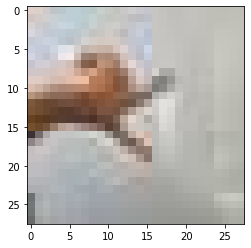

In [11]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 1차 학습
> model1
- epoch = 10
- convolution layer 추가

In [89]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
model1=keras.models.Sequential()
model1.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model1.add(keras.layers.MaxPool2D(2,2))
model1.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model1.add(keras.layers.MaxPooling2D((2,2)))
# convolution 층 추가
model1.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model1.add(keras.layers.MaxPooling2D((2,2)))
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(16, activation='relu'))
model1.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model1.layers))
model1.summary()

Model에 추가된 Layer 개수:  9
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (

In [90]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
model1.compile(optimizer = "adam", 
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

history = model1.fit(x_train_norm, y_train, validation_split=0.25, epochs = 10)

Epoch 1/10
246/246 [==============================] - 1s 5ms/step - loss: 0.9784 - accuracy: 0.5011 - val_loss: 2.3286 - val_accuracy: 0.0000e+00
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.6866 - accuracy: 0.7229 - val_loss: 1.4763 - val_accuracy: 0.2412
Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.4669 - accuracy: 0.8291 - val_loss: 1.0563 - val_accuracy: 0.5255
Epoch 4/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3590 - accuracy: 0.8742 - val_loss: 0.8742 - val_accuracy: 0.6353
Epoch 5/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2755 - accuracy: 0.9118 - val_loss: 0.5618 - val_accuracy: 0.7889
Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2140 - accuracy: 0.9328 - val_loss: 0.3454 - val_accuracy: 0.8754
Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.1770 - accuracy: 0.9451 - val_loss: 0.8932 - val_accuracy: 0.7058
Ep

__학습 결과 시각화__

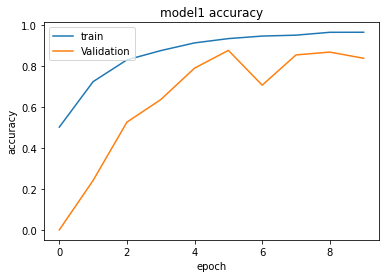

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

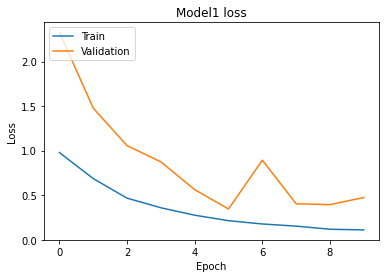

In [92]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model1 loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 1차 테스트

In [93]:
# 테스트 파일 읽고 resize
image_dir_path = "data/test/rock/rock"
resize_images(image_dir_path)
# 테스트 파일 읽고 resize
image_dir_path = "data/test/paper/paper"
resize_images(image_dir_path)
# 테스트 파일 읽고 resize
image_dir_path = "data/test/scissor/scissor"
resize_images(image_dir_path)

212  images to be resized.
212  images resized.
246  images to be resized.
246  images resized.
214  images to be resized.
214  images resized.


In [94]:
import numpy as np

def load_data(img_path, number_of_data=672):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "data/test"
(x_test, y_test)=load_data(image_dir_path, )
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트데이터(x_test)의 이미지 개수는 672 입니다.
x_test shape: (672, 28, 28, 3)
y_test shape: (672,)


In [95]:
# 모델 시험
test_loss, test_accuracy = model1.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

21/21 - 0s - loss: 1.3522 - accuracy: 0.6622
test_loss: 1.352210521697998 
test_accuracy: 0.6622023582458496


__평가__
1. epoch = 7일때 최저점을 찍고 이후에 loss와 accuracy가 상승한다.

### 2차 학습
> model2
- epoch값 7로 변경

In [73]:
# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
model2=keras.models.Sequential()
model2.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model2.add(keras.layers.MaxPool2D(2,2))
model2.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2,2)))
# convolution 층 추가
model2.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2,2)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(16, activation='relu'))
model2.add(keras.layers.Dense(3, activation='softmax'))

print('Model2에 추가된 Layer 개수: ', len(model.layers))
model2.summary()

Model2에 추가된 Layer 개수:  7
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          

In [74]:
# model2을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model2.compile()과 model2.fit()을 사용해 봅시다.
model2.compile(optimizer = "adam", 
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

history = model2.fit(x_train_norm, y_train, validation_split=0.25, epochs = 7)

Epoch 1/7
246/246 [==============================] - 1s 4ms/step - loss: 0.9866 - accuracy: 0.4968 - val_loss: 2.0792 - val_accuracy: 0.0000e+00
Epoch 2/7
246/246 [==============================] - 1s 4ms/step - loss: 0.6987 - accuracy: 0.7232 - val_loss: 1.4807 - val_accuracy: 0.1402
Epoch 3/7
246/246 [==============================] - 1s 4ms/step - loss: 0.4767 - accuracy: 0.8214 - val_loss: 0.7745 - val_accuracy: 0.6357
Epoch 4/7
246/246 [==============================] - 1s 4ms/step - loss: 0.3627 - accuracy: 0.8709 - val_loss: 1.4055 - val_accuracy: 0.3876
Epoch 5/7
246/246 [==============================] - 1s 4ms/step - loss: 0.2786 - accuracy: 0.9061 - val_loss: 0.7780 - val_accuracy: 0.6757
Epoch 6/7
246/246 [==============================] - 1s 4ms/step - loss: 0.2167 - accuracy: 0.9253 - val_loss: 0.4737 - val_accuracy: 0.8319
Epoch 7/7
246/246 [==============================] - 1s 4ms/step - loss: 0.1805 - accuracy: 0.9390 - val_loss: 0.5801 - val_accuracy: 0.7786


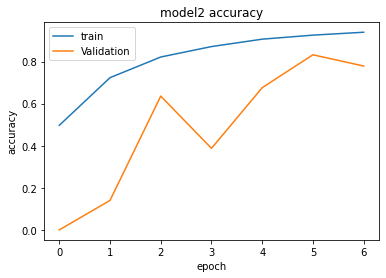

In [75]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

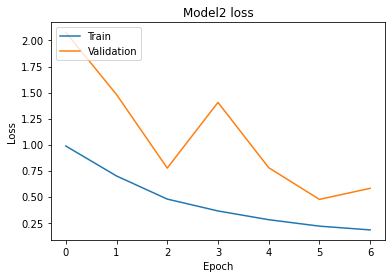

In [76]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model2 loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 2차 테스트

In [77]:
# 테스트 파일 읽고 resize
image_dir_path = "data/test/rock/rock"
resize_images(image_dir_path)
# 테스트 파일 읽고 resize
image_dir_path = "data/test/paper/paper"
resize_images(image_dir_path)
# 테스트 파일 읽고 resize
image_dir_path = "data/test/scissor/scissor"
resize_images(image_dir_path)

212  images to be resized.
212  images resized.
246  images to be resized.
246  images resized.
214  images to be resized.
214  images resized.


In [78]:
import numpy as np

def load_data(img_path, number_of_data=672):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "data/test"
(x_test, y_test)=load_data(image_dir_path, )
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트데이터(x_test)의 이미지 개수는 672 입니다.
x_test shape: (672, 28, 28, 3)
y_test shape: (672,)


In [79]:
# 모델 시험
test_loss, test_accuracy = model2.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

21/21 - 0s - loss: 1.5100 - accuracy: 0.6577
test_loss: 1.5099782943725586 
test_accuracy: 0.6577380895614624


### 3차 학습
> model3
- convolution layer 하나 삭제

In [80]:
model3=keras.models.Sequential()
model3.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model3.add(keras.layers.MaxPool2D(2,2))
model3.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model3.add(keras.layers.MaxPooling2D((2,2)))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(16, activation='relu'))
model3.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))
model3.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                12816     
_________________________________________________________________
dense_17 (Dense)             (

In [81]:
# model3을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model3.compile()과 model3.fit()을 사용해 봅시다.
model3.compile(optimizer = "adam", 
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

history = model3.fit(x_train_norm, y_train, validation_split=0.25, epochs = 7)

Epoch 1/7
246/246 [==============================] - 1s 4ms/step - loss: 0.8029 - accuracy: 0.6439 - val_loss: 1.4897 - val_accuracy: 0.0511
Epoch 2/7
246/246 [==============================] - 1s 3ms/step - loss: 0.4733 - accuracy: 0.8211 - val_loss: 1.2330 - val_accuracy: 0.3590
Epoch 3/7
246/246 [==============================] - 1s 3ms/step - loss: 0.3179 - accuracy: 0.8864 - val_loss: 0.7281 - val_accuracy: 0.6684
Epoch 4/7
246/246 [==============================] - 1s 3ms/step - loss: 0.2273 - accuracy: 0.9239 - val_loss: 0.4991 - val_accuracy: 0.7744
Epoch 5/7
246/246 [==============================] - 1s 3ms/step - loss: 0.1730 - accuracy: 0.9450 - val_loss: 0.4162 - val_accuracy: 0.8331
Epoch 6/7
246/246 [==============================] - 1s 3ms/step - loss: 0.1361 - accuracy: 0.9574 - val_loss: 0.3511 - val_accuracy: 0.8628
Epoch 7/7
246/246 [==============================] - 1s 3ms/step - loss: 0.1085 - accuracy: 0.9658 - val_loss: 0.1929 - val_accuracy: 0.9245


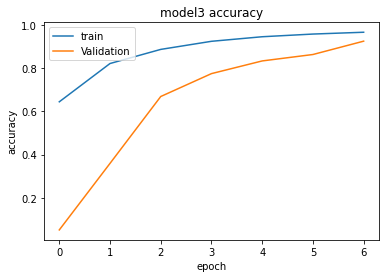

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

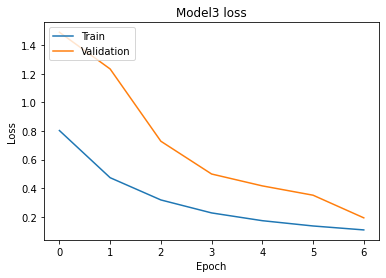

In [83]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model3 loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 3차 테스트

In [84]:
# 테스트 파일 읽고 resize
image_dir_path = "data/test/rock/rock"
resize_images(image_dir_path)
# 테스트 파일 읽고 resize
image_dir_path = "data/test/paper/paper"
resize_images(image_dir_path)
# 테스트 파일 읽고 resize
image_dir_path = "data/test/scissor/scissor"
resize_images(image_dir_path)

212  images to be resized.
212  images resized.
246  images to be resized.
246  images resized.
214  images to be resized.
214  images resized.


In [85]:
import numpy as np

def load_data(img_path, number_of_data=672):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "data/test"
(x_test, y_test)=load_data(image_dir_path, )
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트데이터(x_test)의 이미지 개수는 672 입니다.
x_test shape: (672, 28, 28, 3)
y_test shape: (672,)


In [86]:
# 모델 시험
test_loss, test_accuracy = model3.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

21/21 - 0s - loss: 2.5915 - accuracy: 0.5104
test_loss: 2.591477155685425 
test_accuracy: 0.5104166865348816


__평가__
- 오히려 정확도가 더 떨어짐
- 결과적으로 model1의 성능이 가장 좋음

### 결과 분석

In [87]:
predicted_result = model1.predict(x_test_norm)  # model1이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

예측확률분포: [0.9753566  0.00999152 0.01465188]
라벨: 2, 예측결과: 0


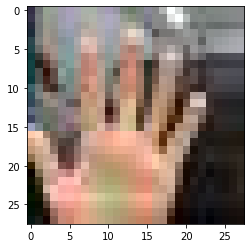

예측확률분포: [9.9851555e-01 9.0056631e-07 1.4835431e-03]
라벨: 2, 예측결과: 0


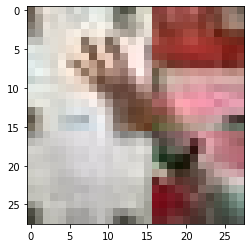

예측확률분포: [0.3177242  0.6740613  0.00821447]
라벨: 2, 예측결과: 1


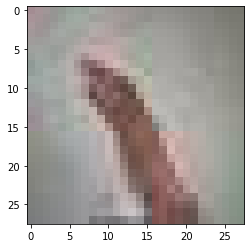

예측확률분포: [0.02583047 0.00713533 0.9670342 ]
라벨: 0, 예측결과: 2


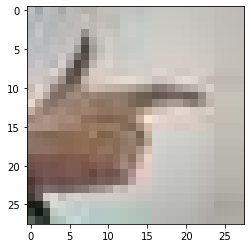

예측확률분포: [0.03526479 0.00447859 0.96025664]
라벨: 0, 예측결과: 2


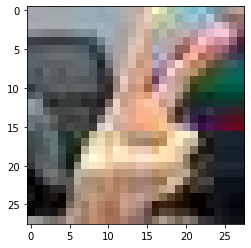

In [88]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

## 회고

1. 처음에 학습데이터에 정확하게 찍힌 사진이 많은것이 좋다고 생각했다. 
1. 그래서 너무 많은 데이터를 학습시키기 보다는 정확하게 찍힌 소수의 사진을 넣으면 정확도가 올라갈줄 알았는데 결과는 그렇지가 않았다. 
1. 그래서 이미지를 많이 추가하니까 정확도가 올라갔다.
1. 또한 레이어를 하나 추가하니까 정확도가 또 올라갔다. 다만 시간은 늘어났다. 
1. 레이어도 줄여보고 epoch도 줄여보고 정규화도 시켜보는 등 다양한 시도를 했지만, 결과적으로는 model1의 성능이 가장 좋았다. 